In [2]:
import pandas as pd

# Load the dataset (adjust filename if needed)
df = pd.read_csv("airport_traffic_2024.csv")

# Preview the data
df.head()


,YEAR,MONTH_NUM,MONTH_MON,FLT_DATE,APT_ICAO,APT_NAME,STATE_NAME,FLT_DEP_1,FLT_ARR_1,FLT_TOT_1,FLT_DEP_IFR_2,FLT_ARR_IFR_2,FLT_TOT_IFR_2
0,2024,1,JAN,01-01-24,LATI,Tirana,Albania,73,74,147,NaN,NaN,NaN
1,2024,1,JAN,01-01-24,UDYZ,Yerevan,Armenia,52,48,100,NaN,NaN,NaN
2,2024,1,JAN,01-01-24,LOWG,Graz,Austria,6,8,14,NaN,NaN,NaN
3,2024,1,JAN,01-01-24,LOWI,Innsbruck,Austria,22,25,47,NaN,NaN,NaN
4,2024,1,JAN,01-01-24,LOWK,Klagenfurt,Austria,2,2,4,NaN,NaN,NaN


In [3]:
# Drop columns with too many missing values
df = df.drop(columns=["FLT_DEP_IFR_2", "FLT_ARR_IFR_2", "FLT_TOT_IFR_2"])

# Check for remaining missing values
print(df.isnull().sum())


YEAR          0
MONTH_NUM     0
MONTH_MON     0
FLT_DATE      0
APT_ICAO      0
APT_NAME      0
STATE_NAME    0
FLT_DEP_1     0
FLT_ARR_1     0
FLT_TOT_1     0
dtype: int64


In [4]:
# Select relevant columns
df = df[["MONTH_NUM", "APT_ICAO", "APT_NAME", "STATE_NAME", "FLT_TOT_1"]]

# Drop rows with missing target
df = df.dropna(subset=["FLT_TOT_1"])

# Check types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114754 entries, 0 to 114753
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   MONTH_NUM   114754 non-null  int64 
 1   APT_ICAO    114754 non-null  object
 2   APT_NAME    114754 non-null  object
 3   STATE_NAME  114754 non-null  object
 4   FLT_TOT_1   114754 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 4.4+ MB


In [5]:
# Select relevant columns
df = df[["MONTH_NUM", "APT_ICAO", "APT_NAME", "STATE_NAME", "FLT_TOT_1"]]

# Drop rows with missing target
df = df.dropna(subset=["FLT_TOT_1"])

# Check types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114754 entries, 0 to 114753
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   MONTH_NUM   114754 non-null  int64 
 1   APT_ICAO    114754 non-null  object
 2   APT_NAME    114754 non-null  object
 3   STATE_NAME  114754 non-null  object
 4   FLT_TOT_1   114754 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 4.4+ MB


In [6]:
# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=["APT_ICAO", "APT_NAME", "STATE_NAME"])

# Split features and target
X = df_encoded.drop(columns=["FLT_TOT_1"])
y = df_encoded["FLT_TOT_1"]


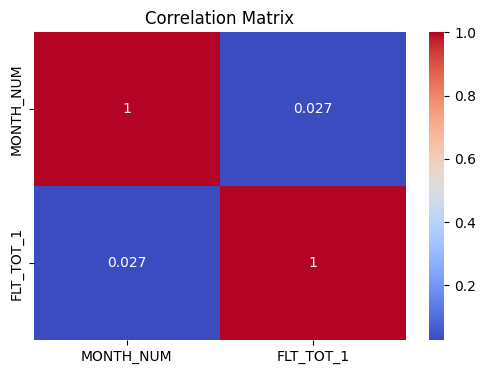

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Only keep numerical columns for correlation analysis
corr_df = df[["MONTH_NUM", "FLT_TOT_1"]]

# Correlation matrix
corr_matrix = corr_df.corr()

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [8]:
# Check impact of APT_NAME on target
top_airports = df.groupby("APT_NAME")["FLT_TOT_1"].mean().sort_values(ascending=False).head(10)
print(top_airports)



APT_NAME
Istanbul                   1401.142077
Amsterdam - Schiphol       1336.259563
London - Heathrow          1301.527322
Paris-Charles-de-Gaulle    1275.327869
Frankfurt                  1204.453552
Madrid - Barajas           1148.418033
Barcelona                   950.797814
Munich                      886.734973
Rome - Fiumicino            862.426230
London - Gatwick            725.122951
Name: FLT_TOT_1, dtype: float64


In [9]:
from sklearn.preprocessing import LabelEncoder

# Copy dataframe
df_model = df[["MONTH_NUM", "APT_NAME", "STATE_NAME", "FLT_TOT_1"]].dropna()

# Encode categorical columns
apt_encoder = LabelEncoder()
state_encoder = LabelEncoder()

df_model["APT_NAME_ENC"] = apt_encoder.fit_transform(df_model["APT_NAME"])
df_model["STATE_ENC"] = state_encoder.fit_transform(df_model["STATE_NAME"])

# Define features and target
X_num = df_model[["MONTH_NUM"]].values
X_cat1 = df_model["APT_NAME_ENC"].values
X_cat2 = df_model["STATE_ENC"].values
y = df_model["FLT_TOT_1"].values


In [10]:
from sklearn.model_selection import train_test_split

X_num_train, X_num_test, X_cat1_train, X_cat1_test, X_cat2_train, X_cat2_test, y_train, y_test = train_test_split(
    X_num, X_cat1, X_cat2, y, test_size=0.2, random_state=42
)


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout

# Inputs
num_input = Input(shape=(1,), name="numerical_input")
cat1_input = Input(shape=(1,), name="apt_name_input")
cat2_input = Input(shape=(1,), name="state_input")

# Embedding layers
apt_vocab_size = df_model["APT_NAME_ENC"].nunique()
state_vocab_size = df_model["STATE_ENC"].nunique()

apt_emb = Embedding(input_dim=apt_vocab_size + 1, output_dim=16)(cat1_input)
state_emb = Embedding(input_dim=state_vocab_size + 1, output_dim=8)(cat2_input)

# Flatten
apt_flat = Flatten()(apt_emb)
state_flat = Flatten()(state_emb)

# Concatenate all features
concat = Concatenate()([num_input, apt_flat, state_flat])

# Dense layers
x = Dense(256, activation='relu')(concat)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1)(x)

# Model
model = Model(inputs=[num_input, cat1_input, cat2_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ apt_name_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ state_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 16)     │      5,312 │ apt_name_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 8)      │        344 │ state_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 25)        │          0 │ numerical_input[… │
│ (Concatenate)       │                   │            │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │      6,656 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,529 (209.10 KB)

 Trainable params: 53,529 (209.10 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    [X_num_train, X_cat1_train, X_cat2_train], y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=256
)


Epoch 1/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 52130.1680 - mae: 118.1441 - val_loss: 2267.6528 - val_mae: 27.4404
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2941.0139 - mae: 29.9811 - val_loss: 1928.3579 - val_mae: 23.6420
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2691.5901 - mae: 27.3076 - val_loss: 1822.0634 - val_mae: 22.1425
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2563.7761 - mae: 26.1804 - val_loss: 1671.0348 - val_mae: 20.9771
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2342.8362 - mae: 24.8595 - val_loss: 1539.0261 - val_mae: 19.8391
Epoch 6/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2287.7927 - mae: 24.3080 - val_loss: 1477.2494 - val_mae: 19.4816
Epoch 7/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2165.8726 - mae: 23.5191 - val_loss: 1390.9778 - val_mae: 19.2064
Epoch 8/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2154.6914 - mae: 23.1230 - val_loss: 1293.0627 - val_m

In [13]:
model.evaluate([X_num_test, X_cat1_test, X_cat2_test], y_test)


718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 826.3292 - mae: 15.4851


[798.7536010742188, 15.22354793548584]

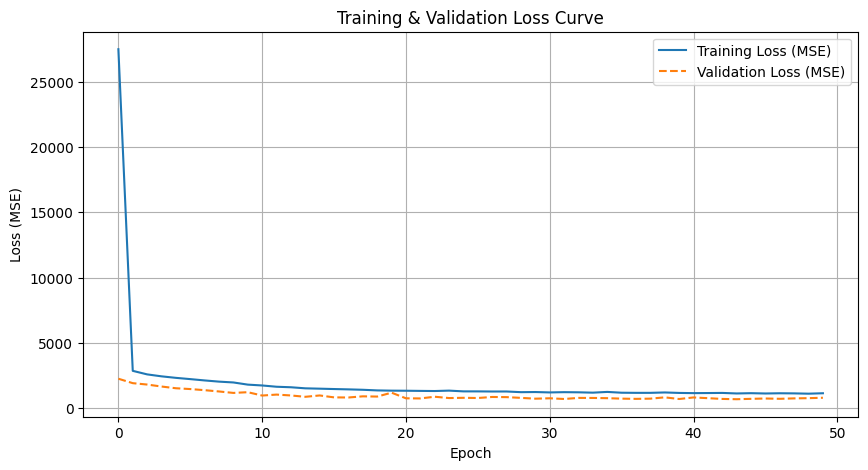

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)', linestyle='--')
plt.title('Training & Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


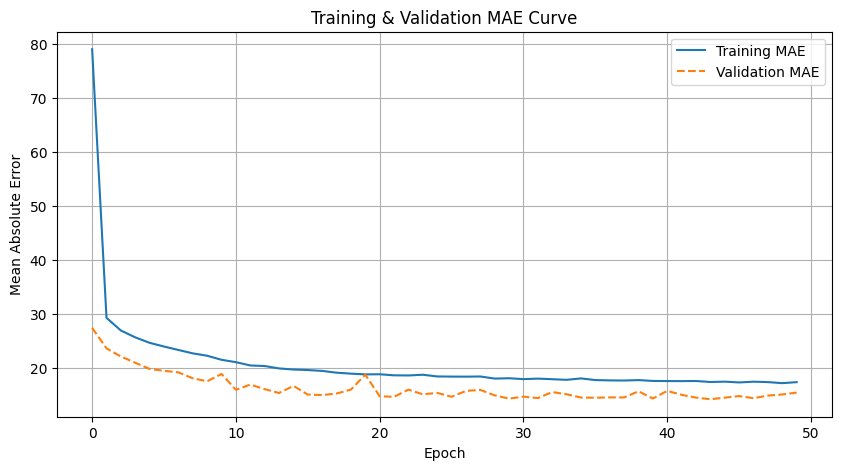

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Training & Validation MAE Curve')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()


718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


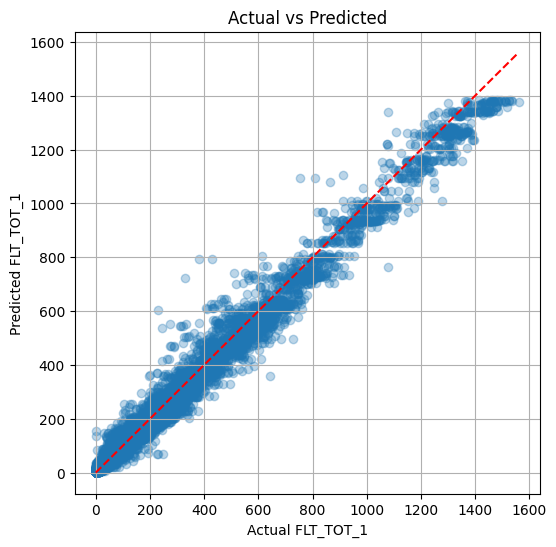

In [16]:
import numpy as np

y_pred = model.predict([X_num_test, X_cat1_test, X_cat2_test])
y_pred = y_pred.flatten()  # Convert to 1D

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual FLT_TOT_1")
plt.ylabel("Predicted FLT_TOT_1")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Flatten prediction output
y_pred = model.predict([X_num_test, X_cat1_test, X_cat2_test]).flatten()

# Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"✅ Final Evaluation on Test Set:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")


718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
✅ Final Evaluation on Test Set:
RMSE: 28.26
MAE: 15.22
R² Score: 0.9858


In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
]

# Retrain with callbacks (increase epochs now that we're protected)
history = model.fit(
    [X_num_train, X_cat1_train, X_cat2_train], y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    callbacks=callbacks
)


Epoch 1/100
279/287 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1091.6339 - mae: 17.0954
Epoch 1: val_loss improved from inf to 752.94458, saving model to best_model.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1092.8551 - mae: 17.1010 - val_loss: 752.9446 - val_mae: 14.7551 - learning_rate: 0.0010
Epoch 2/100
281/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1129.5258 - mae: 17.1591
Epoch 2: val_loss improved from 752.94458 to 738.59412, saving model to best_model.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1129.5299 - mae: 17.1617 - val_loss: 738.5941 - val_mae: 14.3533 - learning_rate: 0.0010
Epoch 3/100
286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1134.6816 - mae: 17.2952
Epoch 3: val_loss improved from 738.59412 to 678.49707, saving model to best_model.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1134.6672 - mae: 17.2950 - val_loss: 678.4971 - val_mae: 14.1768 - learning_rate: 0.0010
Epoch 4/100
283/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1151.1168 - mae: 17.1931
Epoch 4: val_loss did not improve from 678.49707
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1150.6729 - mae: 17.1924 - val_loss: 689.7560 - val_mae: 14.1207 - learning_rate: 0.0010
Epoch 5/100
280/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1083.5814 - mae: 17.0529
Epoch 5: val_loss did not improve from 678.49707
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1083.8917 - mae: 17.0552 - val_loss: 687.4495 - val_mae: 13.9451 - learning_rate: 0.0010
Epoch 6/100
286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1075.0464 - mae: 16.9741
Epoch 6: val_loss did not improve from 678.49707
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1075.3390 - mae: 16.9753 - val_loss: 727.7343 - val_mae: 14.3002 - learning_rate: 0.0010
Epoch 7/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 

287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1074.9381 - mae: 16.7977 - val_loss: 678.1083 - val_mae: 14.3041 - learning_rate: 5.0000e-04
Epoch 10/100
286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1030.4846 - mae: 16.6152
Epoch 10: val_loss improved from 678.10828 to 662.30182, saving model to best_model.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1030.6486 - mae: 16.6159 - val_loss: 662.3018 - val_mae: 14.0580 - learning_rate: 5.0000e-04
Epoch 11/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1049.9987 - mae: 16.6245
Epoch 11: val_loss did not improve from 662.30182
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1050.0402 - mae: 16.6249 - val_loss: 702.3824 - val_mae: 14.4821 - learning_rate: 5.0000e-04
Epoch 12/100
282/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1038.6528 - mae: 16.5863
Epoch 12: val_loss did not improve from 662.30182
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1038.5305 - mae: 16.5854 - val_loss: 703.9653 - val_mae: 14.5660 - learning_rate: 5.0000e-04
Epoch 13/100
282/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1039.0032 - mae: 16.6264
Epoch 13: val_loss did not improve from 662.30182
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1039.0024 - mae: 16.6257 - val_loss: 711.5785 - val_mae: 14.5784 - learning_rate: 5.0000e-04
Epoch 14/100
281/287

287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1015.8048 - mae: 16.4265 - val_loss: 658.0750 - val_mae: 13.8409 - learning_rate: 2.5000e-04
Epoch 18/100
282/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 994.3766 - mae: 16.3798
Epoch 18: val_loss improved from 658.07495 to 646.18964, saving model to best_model.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 994.9500 - mae: 16.3804 - val_loss: 646.1896 - val_mae: 13.7095 - learning_rate: 2.5000e-04
Epoch 19/100
282/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1008.7453 - mae: 16.2480
Epoch 19: val_loss did not improve from 646.18964
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1008.9219 - mae: 16.2503 - val_loss: 651.2942 - val_mae: 13.9078 - learning_rate: 2.5000e-04
Epoch 20/100
283/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 969.1606 - mae: 16.2156
Epoch 20: val_loss did not improve from 646.18964
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 969.6757 - mae: 16.2175 - val_loss: 659.1335 - val_mae: 13.9326 - learning_rate: 2.5000e-04
Epoch 21/100
281/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1009.1964 - mae: 16.3421
Epoch 21: val_loss did not improve from 646.18964
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1009.1513 - mae: 16.3421 - val_loss: 659.8289 - val_mae: 14.0464 - learning_rate: 2.5000e-04
Epoch 22/100
279/287 ━━

287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 996.2896 - mae: 16.2863 - val_loss: 643.8761 - val_mae: 13.8809 - learning_rate: 1.2500e-04
Epoch 25/100
281/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 983.6495 - mae: 16.2255
Epoch 25: val_loss improved from 643.87610 to 643.53998, saving model to best_model.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 983.4679 - mae: 16.2233 - val_loss: 643.5400 - val_mae: 13.8560 - learning_rate: 1.2500e-04
Epoch 26/100
285/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1004.1054 - mae: 16.2370
Epoch 26: val_loss did not improve from 643.53998
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1003.9845 - mae: 16.2374 - val_loss: 646.8571 - val_mae: 13.8516 - learning_rate: 1.2500e-04
Epoch 27/100
286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 990.4122 - mae: 16.2459
Epoch 27: val_loss did not improve from 643.53998
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 990.2407 - mae: 16.2454 - val_loss: 646.6174 - val_mae: 13.7870 - learning_rate: 1.2500e-04
Epoch 28/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1001.4451 - mae: 16.2313
Epoch 28: val_loss improved from 643.53998 to 641.13031, saving model to best_model.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1001.3890 - mae: 16.2311 - val_loss: 641.1303 - val_mae: 13.8000 - learning_rate: 1.2500e-04
Epoch 29/100
280/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1020.7038 - mae: 16.4168
Epoch 29: val_loss did not improve from 641.13031
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1020.0744 - mae: 16.4134 - val_loss: 694.9447 - val_mae: 14.3903 - learning_rate: 1.2500e-04
Epoch 30/100
286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 959.6511 - mae: 16.0646
Epoch 30: val_loss did not improve from 641.13031
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 959.7494 - mae: 16.0653 - val_loss: 652.4884 - val_mae: 13.9841 - learning_rate: 1.2500e-04
Epoch 31/100
285/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 948.8613 - mae: 15.9760
Epoch 31: val_loss did not improve from 641.13031
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 949.1223 - mae: 15.9775 - val_loss: 641.3766 - val_mae: 13.7854 - learning_rate: 1.2500e-04
Epoch 32/100
287/287 ━━━

287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 988.2386 - mae: 16.1966 - val_loss: 640.5399 - val_mae: 13.7671 - learning_rate: 6.2500e-05
Epoch 38/100
283/287 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1006.5583 - mae: 16.1957
Epoch 38: val_loss did not improve from 640.53986
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1006.0153 - mae: 16.1947 - val_loss: 647.4277 - val_mae: 13.9009 - learning_rate: 6.2500e-05
Epoch 39/100
283/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 985.8439 - mae: 16.1999
Epoch 39: val_loss did not improve from 640.53986
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 985.7355 - mae: 16.1986 - val_loss: 646.3380 - val_mae: 13.9015 - learning_rate: 6.2500e-05
Epoch 40/100
282/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 944.8751 - mae: 16.0428
Epoch 40: val_loss did not improve from 640.53986
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 945.3577 - mae: 16.0443 - val_loss: 643.8307 - val_mae: 13.8590 - learning_rate: 6.2500e-05
Epoch 41/100
282/287 ━━━━

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Flatten prediction output
y_pred = model.predict([X_num_test, X_cat1_test, X_cat2_test]).flatten()

# Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"✅ Final Evaluation on Test Set:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")


718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
✅ Final Evaluation on Test Set:
RMSE: 25.83
MAE: 13.75
R² Score: 0.9881


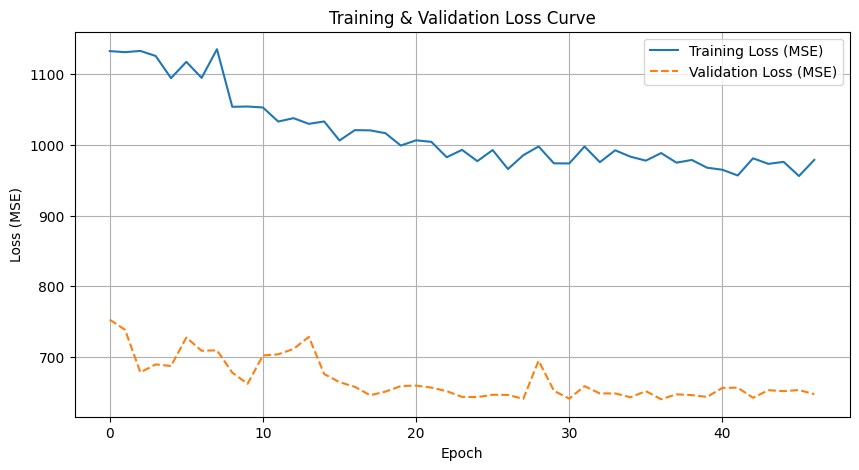

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)', linestyle='--')
plt.title('Training & Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
from tensorflow.keras.layers import LeakyReLU

# Embedding and inputs same as before
apt_emb = Embedding(input_dim=apt_vocab_size + 1, output_dim=16)(cat1_input)
state_emb = Embedding(input_dim=state_vocab_size + 1, output_dim=8)(cat2_input)

apt_flat = Flatten()(apt_emb)
state_flat = Flatten()(state_emb)

concat = Concatenate()([num_input, apt_flat, state_flat])

# Updated dense block
x = Dense(256)(concat)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)

x = Dense(128)(x)
x = LeakyReLU()(x)
x = Dropout(0.1)(x)

x = Dense(64)(x)
x = LeakyReLU()(x)

output = Dense(1)(x)

# Compile model
model = Model(inputs=[num_input, cat1_input, cat2_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [22]:
history = model.fit(
    [X_num_train, X_cat1_train, X_cat2_train], y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    callbacks=callbacks
)


Epoch 1/100
283/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 52592.7461 - mae: 119.6695
Epoch 1: val_loss did not improve from 640.53986
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 52155.7656 - mae: 118.9858 - val_loss: 2152.8003 - val_mae: 26.4789 - learning_rate: 0.0010
Epoch 2/100
286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2639.1206 - mae: 28.5109
Epoch 2: val_loss did not improve from 640.53986
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2638.7117 - mae: 28.5049 - val_loss: 1995.1630 - val_mae: 23.8382 - learning_rate: 0.0010
Epoch 3/100
285/287 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2410.5181 - mae: 25.8940
Epoch 3: val_loss did not improve from 640.53986
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2410.6936 - mae: 25.8919 - val_loss: 1881.9260 - val_mae: 22.1642 - learning_rate: 0.0010
Epoch 4/100
282/287 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2356.7063 - mae: 25.3979
Epoch 4: val_loss did not improve from 640.53986
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/st

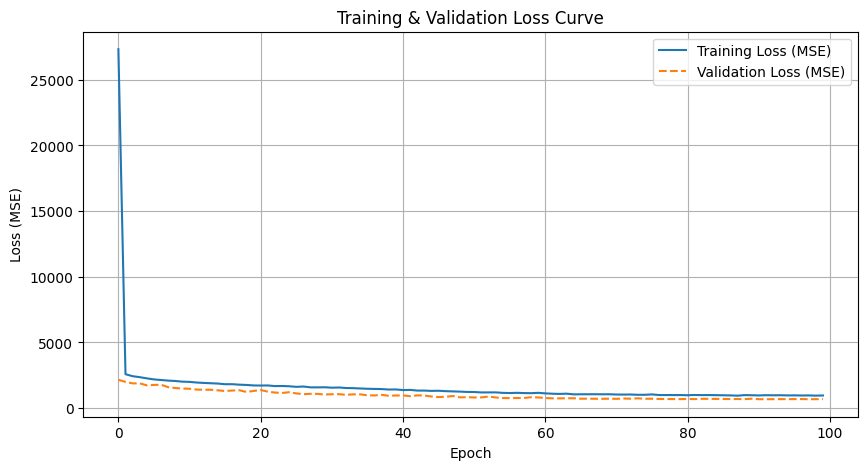

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)', linestyle='--')
plt.title('Training & Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Flatten prediction output
y_pred = model.predict([X_num_test, X_cat1_test, X_cat2_test]).flatten()

# Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"✅ Final Evaluation on Test Set:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")


718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
✅ Final Evaluation on Test Set:
RMSE: 26.58
MAE: 13.87
R² Score: 0.9874


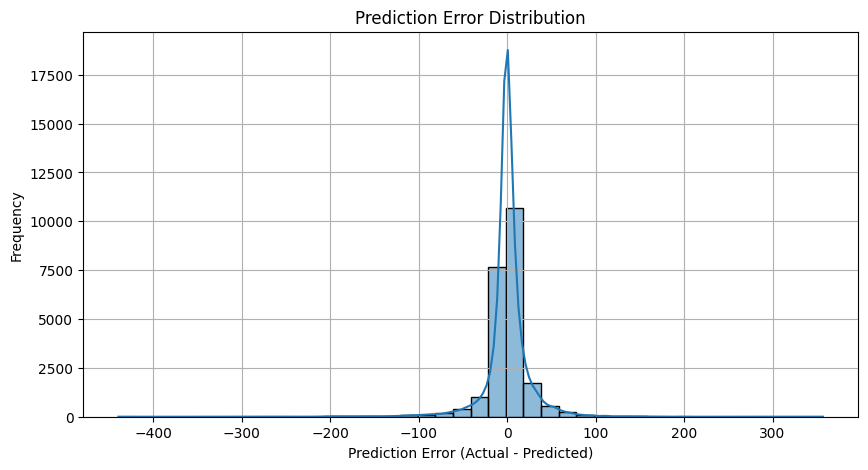

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

errors = y_test - y_pred
plt.figure(figsize=(10,5))
sns.histplot(errors, kde=True, bins=40)
plt.title("Prediction Error Distribution")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


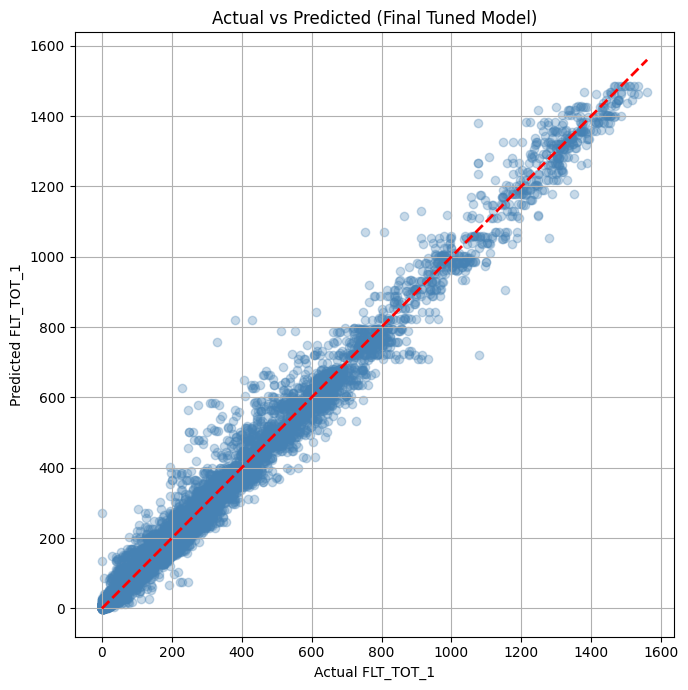

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions
y_pred = model.predict([X_num_test, X_cat1_test, X_cat2_test]).flatten()

# Scatter plot
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.3, color='steelblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual FLT_TOT_1")
plt.ylabel("Predicted FLT_TOT_1")
plt.title("Actual vs Predicted (Final Tuned Model)")
plt.grid(True)
plt.tight_layout()
plt.show()


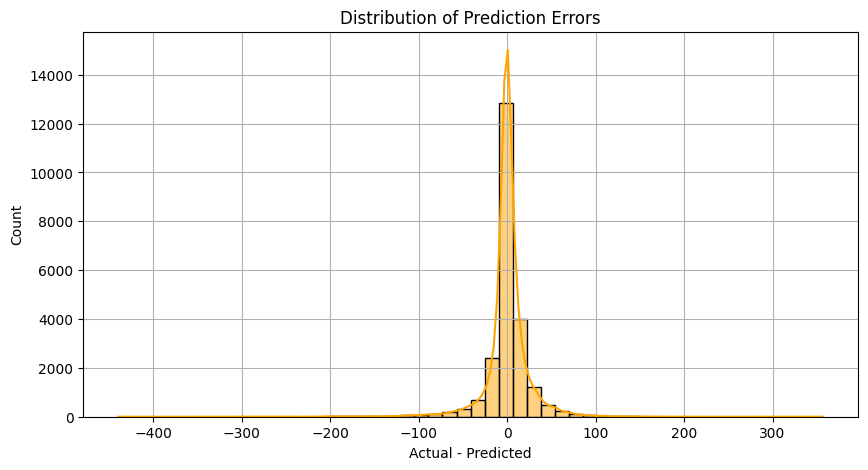

In [27]:
errors = y_test - y_pred
plt.figure(figsize=(10, 5))
sns.histplot(errors, kde=True, bins=50, color='orange')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Actual - Predicted")
plt.grid(True)
plt.show()


In [28]:
print(f"Min: {y_test.min()}, Max: {y_test.max()}, Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")


Min: 0, Max: 1560, Mean: 141.97, Std: 236.98


In [29]:
mae_pct = (mae / y_test.mean()) * 100
rmse_pct = (rmse / y_test.mean()) * 100

print(f"MAE as % of Mean: {mae_pct:.2f}%")
print(f"RMSE as % of Mean: {rmse_pct:.2f}%")


MAE as % of Mean: 9.77%
RMSE as % of Mean: 18.72%


Epoch 1/100
280/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 49297.2539 - mae: 115.1520
Epoch 1: val_loss improved from inf to 2220.77148, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 48627.7969 - mae: 114.0691 - val_loss: 2220.7715 - val_mae: 26.5087 - learning_rate: 0.0010
Epoch 2/100
279/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2666.7380 - mae: 28.2552
Epoch 2: val_loss improved from 2220.77148 to 2042.01233, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2664.4556 - mae: 28.2266 - val_loss: 2042.0123 - val_mae: 23.4505 - learning_rate: 0.0010
Epoch 3/100
285/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2526.3154 - mae: 26.0101
Epoch 3: val_loss improved from 2042.01233 to 1907.79285, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2525.6167 - mae: 26.0056 - val_loss: 1907.7928 - val_mae: 22.2442 - learning_rate: 0.0010
Epoch 4/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2347.8291 - mae: 24.7610
Epoch 4: val_loss improved from 1907.79285 to 1838.64600, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2347.8928 - mae: 24.7611 - val_loss: 1838.6460 - val_mae: 21.4777 - learning_rate: 0.0010
Epoch 5/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2278.6057 - mae: 24.3111
Epoch 5: val_loss improved from 1838.64600 to 1751.82410, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2278.6306 - mae: 24.3108 - val_loss: 1751.8241 - val_mae: 20.8011 - learning_rate: 0.0010
Epoch 6/100
281/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2248.9880 - mae: 24.1896
Epoch 6: val_loss improved from 1751.82410 to 1698.14941, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2247.8240 - mae: 24.1841 - val_loss: 1698.1494 - val_mae: 21.6936 - learning_rate: 0.0010
Epoch 7/100
280/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2197.4380 - mae: 24.0157
Epoch 7: val_loss improved from 1698.14941 to 1589.64539, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2196.3281 - mae: 24.0107 - val_loss: 1589.6454 - val_mae: 20.5625 - learning_rate: 0.0010
Epoch 8/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2088.0864 - mae: 23.4822
Epoch 8: val_loss improved from 1589.64539 to 1521.67468, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2088.0361 - mae: 23.4821 - val_loss: 1521.6747 - val_mae: 19.9562 - learning_rate: 0.0010
Epoch 9/100
285/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1984.4834 - mae: 23.1304
Epoch 9: val_loss improved from 1521.67468 to 1484.50061, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1984.4586 - mae: 23.1304 - val_loss: 1484.5006 - val_mae: 19.5520 - learning_rate: 0.0010
Epoch 10/100
281/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2009.5203 - mae: 23.2431
Epoch 10: val_loss improved from 1484.50061 to 1451.77661, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2008.6594 - mae: 23.2405 - val_loss: 1451.7766 - val_mae: 19.1730 - learning_rate: 0.0010
Epoch 11/100
281/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1966.4983 - mae: 23.2595
Epoch 11: val_loss improved from 1451.77661 to 1437.00867, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1965.5115 - mae: 23.2525 - val_loss: 1437.0087 - val_mae: 19.2983 - learning_rate: 0.0010
Epoch 12/100
281/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1892.8358 - mae: 23.1738
Epoch 12: val_loss improved from 1437.00867 to 1388.79089, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1893.4357 - mae: 23.1717 - val_loss: 1388.7909 - val_mae: 18.7279 - learning_rate: 0.0010
Epoch 13/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1919.3521 - mae: 22.8901
Epoch 13: val_loss improved from 1388.79089 to 1365.27649, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1919.2252 - mae: 22.8900 - val_loss: 1365.2765 - val_mae: 19.0988 - learning_rate: 0.0010
Epoch 14/100
281/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1882.6624 - mae: 22.9165
Epoch 14: val_loss improved from 1365.27649 to 1311.76379, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1882.0125 - mae: 22.9123 - val_loss: 1311.7638 - val_mae: 18.2759 - learning_rate: 0.0010
Epoch 15/100
286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1804.9172 - mae: 22.3490
Epoch 15: val_loss did not improve from 1311.76379
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1805.0316 - mae: 22.3502 - val_loss: 1318.6311 - val_mae: 18.4857 - learning_rate: 0.0010
Epoch 16/100
283/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1768.0405 - mae: 22.3976
Epoch 16: val_loss improved from 1311.76379 to 1268.49158, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1768.8846 - mae: 22.3987 - val_loss: 1268.4916 - val_mae: 17.7982 - learning_rate: 0.0010
Epoch 17/100
283/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1761.6768 - mae: 22.0831
Epoch 17: val_loss did not improve from 1268.49158
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1762.1620 - mae: 22.0858 - val_loss: 1317.8845 - val_mae: 18.5758 - learning_rate: 0.0010
Epoch 18/100
280/287 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1765.4032 - mae: 22.1838
Epoch 18: val_loss did not improve from 1268.49158
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1765.8247 - mae: 22.1842 - val_loss: 1287.6108 - val_mae: 18.5572 - learning_rate: 0.0010
Epoch 19/100
283/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1720.0902 - mae: 21.8431
Epoch 19: val_loss improved from 1268.49158 to 1208.67114, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1720.2682 - mae: 21.8445 - val_loss: 1208.6711 - val_mae: 17.2350 - learning_rate: 0.0010
Epoch 20/100
280/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1726.2100 - mae: 21.7392
Epoch 20: val_loss improved from 1208.67114 to 1194.81812, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1725.5835 - mae: 21.7355 - val_loss: 1194.8181 - val_mae: 17.3877 - learning_rate: 0.0010
Epoch 21/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1661.3555 - mae: 21.4245
Epoch 21: val_loss improved from 1194.81812 to 1163.98413, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1661.5106 - mae: 21.4244 - val_loss: 1163.9841 - val_mae: 17.1648 - learning_rate: 0.0010
Epoch 22/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1687.2120 - mae: 21.4213
Epoch 22: val_loss improved from 1163.98413 to 1153.07886, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1687.1793 - mae: 21.4212 - val_loss: 1153.0789 - val_mae: 16.8777 - learning_rate: 0.0010
Epoch 23/100
280/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1606.9397 - mae: 21.0946
Epoch 23: val_loss improved from 1153.07886 to 1130.60840, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1607.9424 - mae: 21.0958 - val_loss: 1130.6084 - val_mae: 17.0269 - learning_rate: 0.0010
Epoch 24/100
280/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1652.1132 - mae: 21.3133
Epoch 24: val_loss did not improve from 1130.60840
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1652.1637 - mae: 21.3113 - val_loss: 1268.5073 - val_mae: 17.3494 - learning_rate: 0.0010
Epoch 25/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1631.3397 - mae: 20.8429
Epoch 25: val_loss improved from 1130.60840 to 1084.74597, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1631.1957 - mae: 20.8445 - val_loss: 1084.7460 - val_mae: 16.2844 - learning_rate: 0.0010
Epoch 26/100
282/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1552.7040 - mae: 20.7010
Epoch 26: val_loss did not improve from 1084.74597
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1554.0946 - mae: 20.7068 - val_loss: 1105.1963 - val_mae: 16.7335 - learning_rate: 0.0010
Epoch 27/100
285/287 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1568.3943 - mae: 20.6332
Epoch 27: val_loss improved from 1084.74597 to 1071.61145, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1568.5469 - mae: 20.6340 - val_loss: 1071.6115 - val_mae: 16.2715 - learning_rate: 0.0010
Epoch 28/100
285/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1540.5466 - mae: 20.4515
Epoch 28: val_loss did not improve from 1071.61145
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1540.7378 - mae: 20.4522 - val_loss: 1178.6847 - val_mae: 17.1733 - learning_rate: 0.0010
Epoch 29/100
281/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1638.4395 - mae: 20.8480
Epoch 29: val_loss did not improve from 1071.61145
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1637.2631 - mae: 20.8445 - val_loss: 1089.2737 - val_mae: 16.7363 - learning_rate: 0.0010
Epoch 30/100
279/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1576.3627 - mae: 20.6109
Epoch 30: val_loss improved from 1071.61145 to 1022.61292, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1576.1804 - mae: 20.6083 - val_loss: 1022.6129 - val_mae: 15.7403 - learning_rate: 0.0010
Epoch 31/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1528.5060 - mae: 20.5242
Epoch 31: val_loss did not improve from 1022.61292
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1528.7805 - mae: 20.5235 - val_loss: 1060.5630 - val_mae: 16.3756 - learning_rate: 0.0010
Epoch 32/100
285/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1524.4883 - mae: 20.3617
Epoch 32: val_loss improved from 1022.61292 to 1000.80792, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1524.7189 - mae: 20.3627 - val_loss: 1000.8079 - val_mae: 15.6677 - learning_rate: 0.0010
Epoch 33/100
282/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1543.9216 - mae: 20.5199
Epoch 33: val_loss improved from 1000.80792 to 978.91248, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1543.1266 - mae: 20.5141 - val_loss: 978.9125 - val_mae: 15.6595 - learning_rate: 0.0010
Epoch 34/100
283/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1474.0656 - mae: 19.9771
Epoch 34: val_loss did not improve from 978.91248
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1474.1139 - mae: 19.9792 - val_loss: 1014.4822 - val_mae: 15.6349 - learning_rate: 0.0010
Epoch 35/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1495.8413 - mae: 20.1064
Epoch 35: val_loss improved from 978.91248 to 973.85730, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1495.3413 - mae: 20.1049 - val_loss: 973.8573 - val_mae: 15.9694 - learning_rate: 0.0010
Epoch 36/100
280/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1480.1410 - mae: 20.0511
Epoch 36: val_loss improved from 973.85730 to 949.59357, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1479.8594 - mae: 20.0493 - val_loss: 949.5936 - val_mae: 15.7021 - learning_rate: 0.0010
Epoch 37/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1431.3059 - mae: 19.7726
Epoch 37: val_loss improved from 949.59357 to 929.14594, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1431.2340 - mae: 19.7723 - val_loss: 929.1459 - val_mae: 15.4120 - learning_rate: 0.0010
Epoch 38/100
286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1449.5658 - mae: 19.9009
Epoch 38: val_loss did not improve from 929.14594
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1449.2478 - mae: 19.9000 - val_loss: 937.3406 - val_mae: 15.2546 - learning_rate: 0.0010
Epoch 39/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1403.0930 - mae: 19.7536
Epoch 39: val_loss did not improve from 929.14594
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1403.1218 - mae: 19.7536 - val_loss: 934.8102 - val_mae: 15.6861 - learning_rate: 0.0010
Epoch 40/100
282/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1349.6356 - mae: 19.3859
Epoch 40: val_loss improved from 929.14594 to 918.35687, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1349.6542 - mae: 19.3861 - val_loss: 918.3569 - val_mae: 15.2802 - learning_rate: 0.0010
Epoch 41/100
285/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1365.3002 - mae: 19.5235
Epoch 41: val_loss improved from 918.35687 to 864.69269, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1364.9701 - mae: 19.5221 - val_loss: 864.6927 - val_mae: 15.1111 - learning_rate: 0.0010
Epoch 42/100
286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1356.2546 - mae: 19.3044
Epoch 42: val_loss did not improve from 864.69269
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1356.0454 - mae: 19.3043 - val_loss: 867.1166 - val_mae: 15.3749 - learning_rate: 0.0010
Epoch 43/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1319.4296 - mae: 19.1990
Epoch 43: val_loss did not improve from 864.69269
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1319.3337 - mae: 19.1987 - val_loss: 888.1848 - val_mae: 15.1720 - learning_rate: 0.0010
Epoch 44/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1292.8759 - mae: 19.1860
Epoch 44: val_loss improved from 864.69269 to 847.91730, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1292.9899 - mae: 19.1862 - val_loss: 847.9173 - val_mae: 15.1768 - learning_rate: 0.0010
Epoch 45/100
286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1232.9084 - mae: 19.0716
Epoch 45: val_loss improved from 847.91730 to 811.14294, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1233.0925 - mae: 19.0715 - val_loss: 811.1429 - val_mae: 14.8640 - learning_rate: 0.0010
Epoch 46/100
282/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1247.9438 - mae: 18.9829
Epoch 46: val_loss did not improve from 811.14294
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1247.4304 - mae: 18.9812 - val_loss: 860.2537 - val_mae: 15.4980 - learning_rate: 0.0010
Epoch 47/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1194.6094 - mae: 18.6317
Epoch 47: val_loss improved from 811.14294 to 780.77728, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1194.8821 - mae: 18.6342 - val_loss: 780.7773 - val_mae: 14.6489 - learning_rate: 0.0010
Epoch 48/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1180.1685 - mae: 18.6655
Epoch 48: val_loss did not improve from 780.77728
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1180.4098 - mae: 18.6668 - val_loss: 813.1222 - val_mae: 14.9729 - learning_rate: 0.0010
Epoch 49/100
286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1193.3314 - mae: 18.7747
Epoch 49: val_loss did not improve from 780.77728
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1193.2642 - mae: 18.7740 - val_loss: 791.8129 - val_mae: 14.8871 - learning_rate: 0.0010
Epoch 50/100
283/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1188.0793 - mae: 18.6680
Epoch 50: val_loss improved from 780.77728 to 768.53174, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1188.1675 - mae: 18.6673 - val_loss: 768.5317 - val_mae: 14.6670 - learning_rate: 0.0010
Epoch 51/100
280/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1126.4102 - mae: 18.3880
Epoch 51: val_loss improved from 768.53174 to 757.09546, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1126.9773 - mae: 18.3895 - val_loss: 757.0955 - val_mae: 14.7295 - learning_rate: 0.0010
Epoch 52/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1129.2872 - mae: 18.2660
Epoch 52: val_loss did not improve from 757.09546
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1129.7656 - mae: 18.2691 - val_loss: 765.6849 - val_mae: 14.8191 - learning_rate: 0.0010
Epoch 53/100
281/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1112.9944 - mae: 18.2901
Epoch 53: val_loss did not improve from 757.09546
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1113.1654 - mae: 18.2914 - val_loss: 810.4440 - val_mae: 15.3492 - learning_rate: 0.0010
Epoch 54/100
286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1153.7173 - mae: 18.3945
Epoch 54: val_loss improved from 757.09546 to 749.06158, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1153.5077 - mae: 18.3936 - val_loss: 749.0616 - val_mae: 14.3681 - learning_rate: 0.0010
Epoch 55/100
283/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1045.4611 - mae: 17.8411
Epoch 55: val_loss did not improve from 749.06158
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1046.2725 - mae: 17.8461 - val_loss: 881.1824 - val_mae: 16.4262 - learning_rate: 0.0010
Epoch 56/100
283/287 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1117.8192 - mae: 18.2185
Epoch 56: val_loss did not improve from 749.06158
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1117.4854 - mae: 18.2179 - val_loss: 762.1528 - val_mae: 14.9642 - learning_rate: 0.0010
Epoch 57/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1087.0387 - mae: 18.1151
Epoch 57: val_loss did not improve from 749.06158
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1087.0499 - mae: 18.1149 - val_loss: 787.8136 - val_mae: 14.9902 - learning_rate: 0.0010
Epoch 58/100
283/287 ━━━━━━━━━━━━━━━

287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1067.8171 - mae: 17.9273 - val_loss: 742.5694 - val_mae: 14.7216 - learning_rate: 0.0010
Epoch 60/100
285/287 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1044.4543 - mae: 17.8046
Epoch 60: val_loss improved from 742.56940 to 731.87030, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1044.6298 - mae: 17.8056 - val_loss: 731.8703 - val_mae: 14.5869 - learning_rate: 0.0010
Epoch 61/100
282/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1067.8788 - mae: 17.7879
Epoch 61: val_loss did not improve from 731.87030
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1067.6396 - mae: 17.7877 - val_loss: 790.5625 - val_mae: 15.3380 - learning_rate: 0.0010
Epoch 62/100
282/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1017.9725 - mae: 17.5429
Epoch 62: val_loss did not improve from 731.87030
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1018.8166 - mae: 17.5495 - val_loss: 829.2994 - val_mae: 15.9793 - learning_rate: 0.0010
Epoch 63/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1039.6550 - mae: 17.7096
Epoch 63: val_loss improved from 731.87030 to 712.53735, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1039.7385 - mae: 17.7108 - val_loss: 712.5374 - val_mae: 14.2760 - learning_rate: 0.0010
Epoch 64/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 997.7372 - mae: 17.5200
Epoch 64: val_loss did not improve from 712.53735
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 998.2219 - mae: 17.5220 - val_loss: 766.7639 - val_mae: 14.6791 - learning_rate: 0.0010
Epoch 65/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1052.0515 - mae: 17.8367
Epoch 65: val_loss improved from 712.53735 to 704.41864, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1051.9768 - mae: 17.8360 - val_loss: 704.4186 - val_mae: 14.4709 - learning_rate: 0.0010
Epoch 66/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1026.8921 - mae: 17.5745
Epoch 66: val_loss did not improve from 704.41864
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1026.7726 - mae: 17.5738 - val_loss: 707.5648 - val_mae: 14.2055 - learning_rate: 0.0010
Epoch 67/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1008.1855 - mae: 17.4560
Epoch 67: val_loss did not improve from 704.41864
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1008.4673 - mae: 17.4573 - val_loss: 838.7108 - val_mae: 15.6503 - learning_rate: 0.0010
Epoch 68/100
283/287 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 985.7515 - mae: 17.4939
Epoch 68: val_loss did not improve from 704.41864
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 985.9470 - mae: 17.4941 - val_loss: 746.4620 - val_mae: 14.9792 - learning_rate: 0.0010
Epoch 69/100
287/287 ━━━━━━━━━━━━━━━━━

287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 994.4639 - mae: 17.2158 - val_loss: 682.1657 - val_mae: 14.1286 - learning_rate: 5.0000e-04
Epoch 72/100
285/287 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1005.6370 - mae: 17.1924
Epoch 72: val_loss did not improve from 682.16571
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1005.1019 - mae: 17.1898 - val_loss: 690.7790 - val_mae: 14.1736 - learning_rate: 5.0000e-04
Epoch 73/100
286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 910.7547 - mae: 16.7280
Epoch 73: val_loss did not improve from 682.16571
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 911.0364 - mae: 16.7294 - val_loss: 697.2494 - val_mae: 14.4562 - learning_rate: 5.0000e-04
Epoch 74/100
282/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 942.3641 - mae: 16.9458
Epoch 74: val_loss improved from 682.16571 to 681.97711, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 942.3239 - mae: 16.9445 - val_loss: 681.9771 - val_mae: 14.1002 - learning_rate: 5.0000e-04
Epoch 75/100
286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 941.1205 - mae: 16.8811
Epoch 75: val_loss did not improve from 681.97711
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 941.1871 - mae: 16.8814 - val_loss: 686.9134 - val_mae: 14.1371 - learning_rate: 5.0000e-04
Epoch 76/100
281/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 960.1929 - mae: 16.9791
Epoch 76: val_loss did not improve from 681.97711
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 960.1316 - mae: 16.9797 - val_loss: 688.1863 - val_mae: 14.2638 - learning_rate: 5.0000e-04
Epoch 77/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 953.2021 - mae: 17.0046
Epoch 77: val_loss improved from 681.97711 to 680.88177, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 953.2241 - mae: 17.0041 - val_loss: 680.8818 - val_mae: 13.9368 - learning_rate: 5.0000e-04
Epoch 78/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 961.6443 - mae: 16.8253
Epoch 78: val_loss improved from 680.88177 to 669.20813, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 961.6074 - mae: 16.8255 - val_loss: 669.2081 - val_mae: 14.0712 - learning_rate: 5.0000e-04
Epoch 79/100
281/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 924.1789 - mae: 16.8333
Epoch 79: val_loss did not improve from 669.20813
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 924.4530 - mae: 16.8342 - val_loss: 718.7640 - val_mae: 14.9237 - learning_rate: 5.0000e-04
Epoch 80/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 960.1754 - mae: 16.9172
Epoch 80: val_loss did not improve from 669.20813
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 960.0605 - mae: 16.9177 - val_loss: 718.3886 - val_mae: 14.5622 - learning_rate: 5.0000e-04
Epoch 81/100
283/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 967.3528 - mae: 16.8964
Epoch 81: val_loss did not improve from 669.20813
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 966.9238 - mae: 16.8947 - val_loss: 684.6115 - val_mae: 14.2996 - learning_rate: 5.0000e-04
Epoch 82/100
287/287 ━━━━━━━

287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 943.4972 - mae: 16.7489 - val_loss: 666.2815 - val_mae: 13.8733 - learning_rate: 2.5000e-04
Epoch 85/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 899.6365 - mae: 16.4798
Epoch 85: val_loss did not improve from 666.28149
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 899.8218 - mae: 16.4806 - val_loss: 670.7858 - val_mae: 13.9272 - learning_rate: 2.5000e-04
Epoch 86/100
286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 924.7452 - mae: 16.6089
Epoch 86: val_loss did not improve from 666.28149
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 924.6758 - mae: 16.6086 - val_loss: 676.4316 - val_mae: 14.0196 - learning_rate: 2.5000e-04
Epoch 87/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 885.6342 - mae: 16.4517
Epoch 87: val_loss did not improve from 666.28149
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 885.6855 - mae: 16.4518 - val_loss: 668.4379 - val_mae: 13.7592 - learning_rate: 2.5000e-04
Epoch 88/100
285/287 ━━━━━

287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 922.5312 - mae: 16.6181 - val_loss: 665.2589 - val_mae: 13.9510 - learning_rate: 2.5000e-04
Epoch 90/100
282/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 903.0400 - mae: 16.5328
Epoch 90: val_loss did not improve from 665.25885
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 903.0815 - mae: 16.5330 - val_loss: 674.8609 - val_mae: 13.8858 - learning_rate: 2.5000e-04
Epoch 91/100
286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 891.4017 - mae: 16.3872
Epoch 91: val_loss improved from 665.25885 to 659.53516, saving model to best_model_tier.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 891.5726 - mae: 16.3879 - val_loss: 659.5352 - val_mae: 13.7272 - learning_rate: 2.5000e-04
Epoch 92/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 899.4578 - mae: 16.4646
Epoch 92: val_loss did not improve from 659.53516
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 899.5079 - mae: 16.4649 - val_loss: 664.3954 - val_mae: 13.7607 - learning_rate: 2.5000e-04
Epoch 93/100
284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 890.2335 - mae: 16.4389
Epoch 93: val_loss did not improve from 659.53516
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 890.1458 - mae: 16.4381 - val_loss: 666.2582 - val_mae: 13.9549 - learning_rate: 2.5000e-04
Epoch 94/100
285/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 905.2629 - mae: 16.4366
Epoch 94: val_loss did not improve from 659.53516
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 905.3044 - mae: 16.4371 - val_loss: 675.2119 - val_mae: 14.0053 - learning_rate: 2.5000e-04
Epoch 95/100
287/287 ━━━━━

287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 901.6783 - mae: 16.3637 - val_loss: 658.9541 - val_mae: 13.8412 - learning_rate: 1.2500e-04
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Final Evaluation with `airport_tier` Feature:
RMSE: 26.19
MAE: 13.85
R² Score: 0.9878


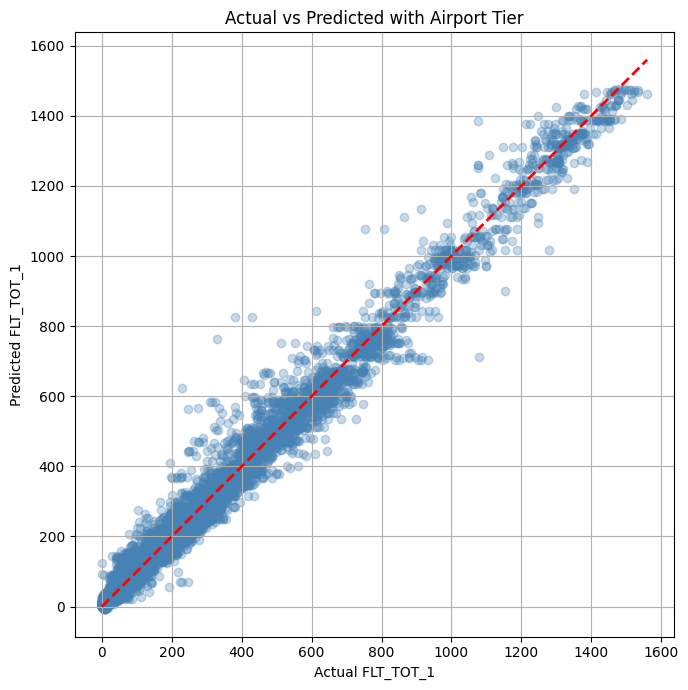

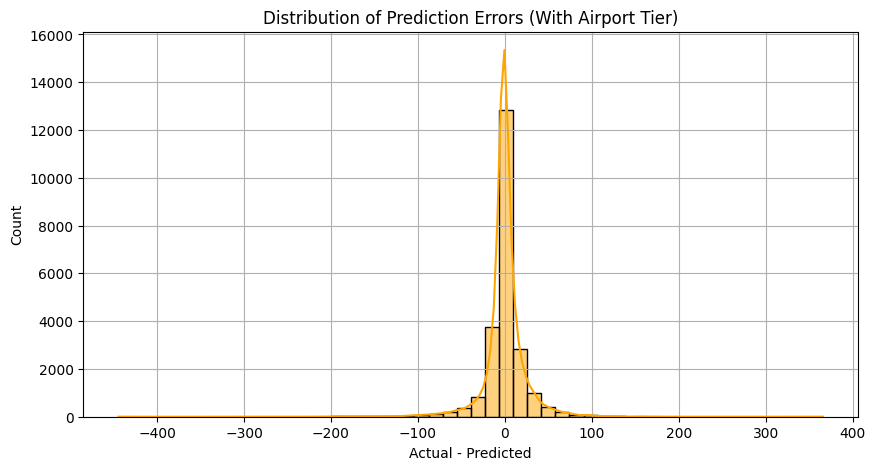

In [4]:
# ✅ Step 1: Install TensorFlow (usually pre-installed in Colab)
# !pip install tensorflow seaborn

# ✅ Step 2: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Concatenate, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

# Replace with your file name if different
df = pd.read_csv("airport_traffic_2024.csv")

# ✅ Step 4: Data Cleaning & Encoding
df = df.drop(columns=["FLT_DEP_IFR_2", "FLT_ARR_IFR_2", "FLT_TOT_IFR_2"])
df = df[["MONTH_NUM", "APT_NAME", "STATE_NAME", "FLT_TOT_1"]].dropna()

apt_encoder = LabelEncoder()
state_encoder = LabelEncoder()
df["APT_NAME_ENC"] = apt_encoder.fit_transform(df["APT_NAME"])
df["STATE_ENC"] = state_encoder.fit_transform(df["STATE_NAME"])

# ✅ Step 5: Add `airport_tier` Feature
airport_avg = df.groupby("APT_NAME")["FLT_TOT_1"].mean()
def assign_tier(avg):
    if avg > 600:
        return "High"
    elif avg > 150:
        return "Medium"
    else:
        return "Low"
df["airport_avg"] = df["APT_NAME"].map(airport_avg)
df["airport_tier"] = df["airport_avg"].apply(assign_tier)
tier_encoder = LabelEncoder()
df["airport_tier_enc"] = tier_encoder.fit_transform(df["airport_tier"])

# ✅ Step 6: Prepare Features & Target
X_num = df[["MONTH_NUM"]].values
X_cat1 = df["APT_NAME_ENC"].values
X_cat2 = df["STATE_ENC"].values
X_cat3 = df["airport_tier_enc"].values
y = df["FLT_TOT_1"].values

X_num_train, X_num_test, X_cat1_train, X_cat1_test, X_cat2_train, X_cat2_test, X_cat3_train, X_cat3_test, y_train, y_test = train_test_split(
    X_num, X_cat1, X_cat2, X_cat3, y, test_size=0.2, random_state=42
)

# ✅ Step 7: Build Model
apt_vocab_size = df["APT_NAME_ENC"].nunique()
state_vocab_size = df["STATE_ENC"].nunique()
tier_vocab_size = df["airport_tier_enc"].nunique()

num_input = Input(shape=(1,), name="numerical_input")
cat1_input = Input(shape=(1,), name="apt_name_input")
cat2_input = Input(shape=(1,), name="state_input")
cat3_input = Input(shape=(1,), name="tier_input")

apt_emb = Embedding(input_dim=apt_vocab_size + 1, output_dim=16)(cat1_input)
state_emb = Embedding(input_dim=state_vocab_size + 1, output_dim=8)(cat2_input)
tier_emb = Embedding(input_dim=tier_vocab_size + 1, output_dim=4)(cat3_input)

apt_flat = Flatten()(apt_emb)
state_flat = Flatten()(state_emb)
tier_flat = Flatten()(tier_emb)

concat = Concatenate()([num_input, apt_flat, state_flat, tier_flat])

x = Dense(256)(concat)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)
x = Dense(128)(x)
x = LeakyReLU()(x)
x = Dropout(0.1)(x)
x = Dense(64)(x)
x = LeakyReLU()(x)
output = Dense(1)(x)

model = Model(inputs=[num_input, cat1_input, cat2_input, cat3_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# ✅ Step 8: Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint("best_model_tier.h5", monitor='val_loss', save_best_only=True, verbose=1)
]

# ✅ Step 9: Train Model
history = model.fit(
    [X_num_train, X_cat1_train, X_cat2_train, X_cat3_train], y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    callbacks=callbacks
)

# ✅ Step 10: Evaluate Model
y_pred = model.predict([X_num_test, X_cat1_test, X_cat2_test, X_cat3_test]).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("✅ Final Evaluation with `airport_tier` Feature:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# ✅ Step 11: Visualizations
# Actual vs Predicted
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.3, color='steelblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual FLT_TOT_1")
plt.ylabel("Predicted FLT_TOT_1")
plt.title("Actual vs Predicted with Airport Tier")
plt.grid(True)
plt.tight_layout()
plt.show()

# Residuals
errors = y_test - y_pred
plt.figure(figsize=(10, 5))
sns.histplot(errors, kde=True, bins=50, color='orange')
plt.title("Distribution of Prediction Errors (With Airport Tier)")
plt.xlabel("Actual - Predicted")
plt.grid(True)
plt.show()


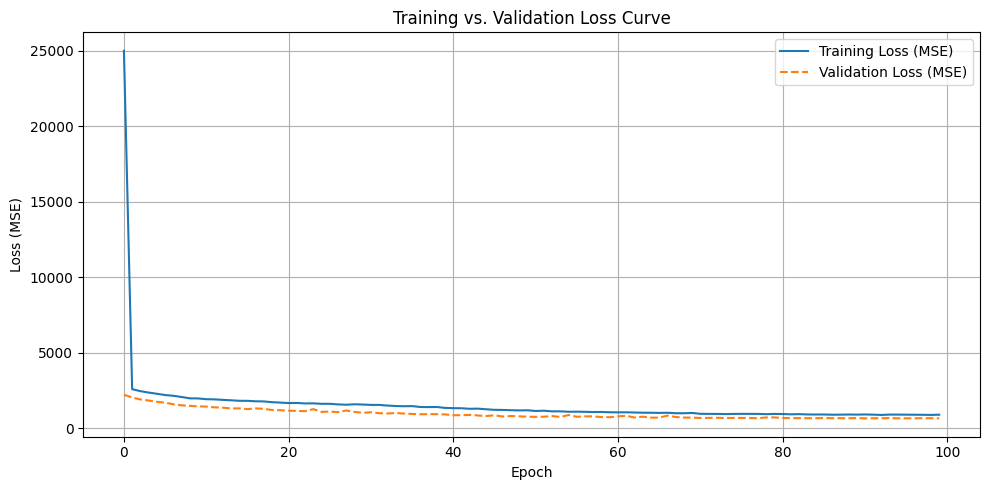

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)', linestyle='--')
plt.title('Training vs. Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


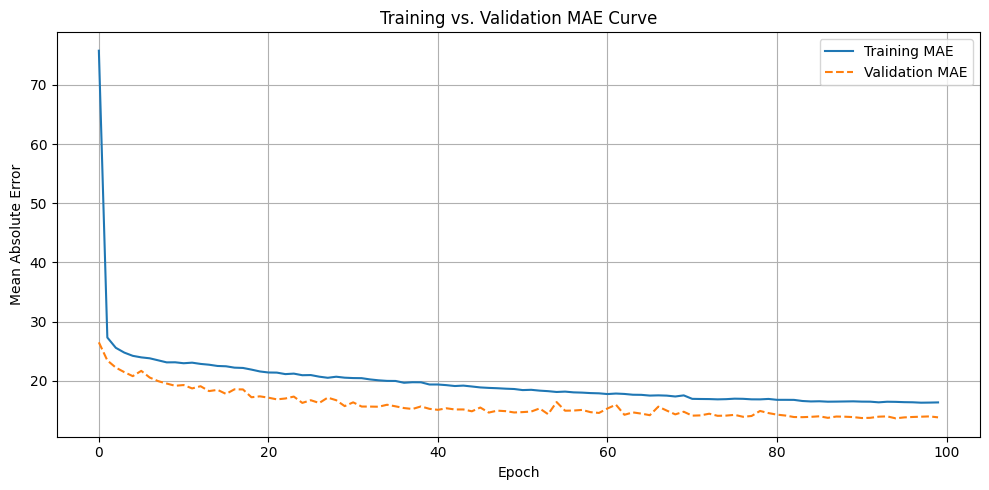

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Training vs. Validation MAE Curve')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
